In [67]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import sys
sys.path.append('..')

import modules.stats as st
import modules.plotting as pl
import modules.pandas_funcs as pf

In [68]:
results_dir = os.path.join('..', 'data', 'results')
match_dir = os.path.join('..', 'data', 'matching')


df_k_raw = pd.read_csv(os.path.join(results_dir, 'kinect_gait_metrics.csv'),
                       index_col=0)

df_z_raw = pd.read_csv(os.path.join(results_dir, 'zeno_gait_metrics.csv'),
                       index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)


df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(df_match_zeno, df_k_raw, left_on='Kinect',
                    right_index=True, suffixes=('_z', '_k'))


# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

# Group by gait metric without suffix
df_k_grouped = df_k.groupby(lambda x: x[:-2], axis=1).mean()
df_z_grouped = df_z.groupby(lambda x: x[:-2], axis=1).mean()

## Visual Results

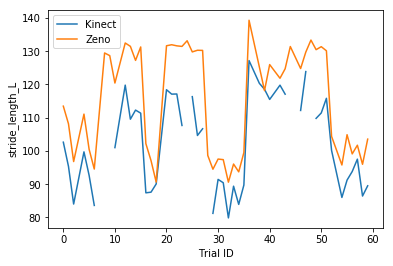

In [69]:
%matplotlib inline

metric = 'stride_length_L'

plt.plot(df_k[metric])
plt.plot(df_z[metric])

plt.xlabel('Trial ID')
plt.ylabel(metric)

plt.legend(['Kinect', 'Zeno'])
plt.show()

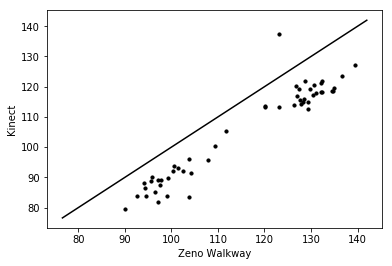

In [70]:
x_label, y_label = 'Zeno Walkway', 'Kinect'
metric = 'stride_length_R'
    
pl.compare_measurements(df_z[metric], df_k[metric], c='k', s=10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

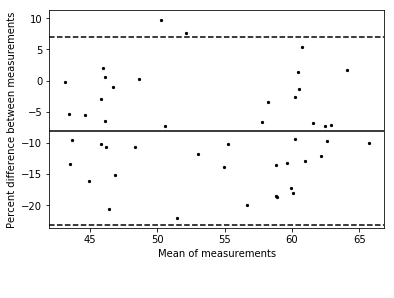

In [71]:
metric = 'step_length_L'

# Bland-Altman object
bland_obj = st.BlandAltman(df_k[metric], df_z[metric], percent=True)

pl.plot_bland_altman(bland_obj.means, bland_obj.differences, bland_obj.bias, 
                     bland_obj.limits_of_agreement, percent=True)

## Quantitative Results

In [72]:
funcs = {'Pearson': lambda a, b: pearsonr(a, b)[0],
        'Spearman': lambda a, b: spearmanr(a, b)[0],
        'Abs rel error': lambda a, b: st.relative_error(a, b, absolute=True).mean(),
        'Bias': lambda a, b: st.BlandAltman(a, b).bias, 
        'Range': lambda a, b: st.BlandAltman(a, b).range}
 
    
d = {name: pf.apply_to_columns(df_k, df_z, func) for name, func in funcs.items()}

df_results = pd.DataFrame(d).T
df_results

,absolute_step_length_L,absolute_step_length_R,step_length_L,step_length_R,stride_length_L,stride_length_R,stride_time_L,stride_time_R,stride_velocity_L,stride_velocity_R,stride_width_L,stride_width_R
Pearson,0.812129,0.842875,0.845629,0.850707,0.923587,0.953841,0.916708,0.923430,0.937329,0.967245,0.696108,0.754473
Spearman,0.756522,0.862717,0.797965,0.833774,0.859759,0.901197,0.713180,0.739850,0.809559,0.876206,0.666728,0.684795
Abs rel error,0.080524,0.106645,0.088452,0.127469,0.102043,0.095186,0.180774,0.170568,0.114083,0.098042,4.470797,4.864411
Bias,-0.064732,-0.102588,-0.081364,-0.127257,-0.108577,-0.095938,-0.202695,-0.190045,0.085408,0.083268,0.868923,0.868205
Range,0.313465,0.293453,0.301194,0.340889,0.200021,0.165806,0.370601,0.352665,0.379717,0.292355,4.737881,6.277739


In [73]:
d = {name: pf.apply_to_columns(df_k_grouped, df_z_grouped, func) for name, func in funcs.items()}

df_grouped = pd.DataFrame(d).T
df_grouped

,absolute_step_length,step_length,stride_length,stride_time,stride_velocity,stride_width
Pearson,0.909058,0.921472,0.964610,0.936196,0.961114,0.759747
Spearman,0.845983,0.834201,0.882780,0.709015,0.847093,0.727055
Abs rel error,0.082569,0.101228,0.096133,0.174224,0.100584,2.471091
Bias,-0.081202,-0.102355,-0.101329,-0.193810,0.084286,0.840300
Range,0.200782,0.207454,0.141138,0.320356,0.298759,4.945819


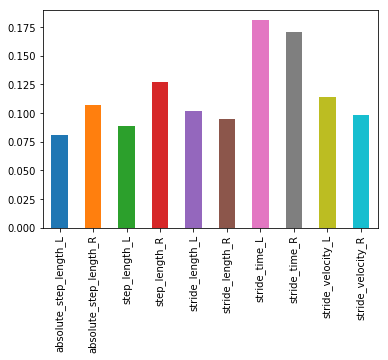

In [74]:
df_results.loc['Abs rel error'][:-2].plot.bar()

In [75]:
df_sides = df_results.groupby(lambda x: x.split('_')[-1], axis=1).mean()
df_sides

,L,R
Pearson,0.855248,0.882095
Spearman,0.767286,0.816423
Abs rel error,0.839445,0.910387
Bias,0.082827,0.072608
Range,1.050480,1.287151


In [76]:
df_grouped.stride_length * 100

Pearson          96.460970
Spearman         88.277982
Abs rel error     9.613335
Bias            -10.132871
Range            14.113773
Name: stride_length, dtype: float64

In [77]:
df_rel_error = abs(df_k - df_z) / df_z * 100

In [78]:
max_idx = df_rel_error.stride_length_L.idxmax()